In [86]:
#from board import experiment
import numpy as np
from scipy.stats import skew, mode, skewnorm
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
#n_data = 1000 # Number of times to run the experiment

#data = np.zeros((n_data, 32))
#for i in range(0, n_data):
#    print(f"{i+1}/{n_data}\r", end="")
#    data[i,:] = experiment()

#np.save("experiment_data.npy", data)

In [3]:
# Loads data from experiment_data.npy file
# Contains data for 1000 experiments
# If we need more data I can only do it on the computers at Chalmers
experiment_data = np.load("experiment_data.npy")
n_experiment = experiment_data.shape[0]

# Dummy experiment function that reads pregenerated data
i_experiment = 0
def experiment():
    global i_experiment
    result = experiment_data[i_experiment,:]
    i_experiment = i_experiment+1
    if i_experiment >= n_experiment: 
        i_experiment = 0
        print("Warning: reusing old experiments")
    return result

In [114]:
# Simulate the experiment with known s and alpha
def simulate_exp(alpha, s, num_rows = 31):
    # Simulates an experiment for given alpha and s values
    num_beads = num_rows + 1 # Number of beads at the bottom of the Galton board
    results = np.zeros(num_beads)
    
    for _ in range(1000):  # Number of balls
        M = 0  # Initial memory factor
        pos = (num_rows) / 2  # Starting position
        
        # Iterate over each row of pegs
        for ix in range(num_rows):
            # Calculate the probability of falling right
            P_right = 0.5 + (alpha * M + s)

            # Random decision for the bead's direction
            if np.random.uniform(0, 1) < P_right:
                pos += 0.5  # Move right
                M = 0.5  # Update memory factor
            else:
                pos -= 0.5  # Move left
                M = -0.5  # Update memory factor

        # Determine the final position of the ball
        pos = int(np.round(pos))
        results[pos] += 1

    return results.astype(int)



In [111]:
# Generate data with known s and alpha
X = []
target = []
alphas = np.linspace(0,0.5,10)
ses = np.linspace(-0.25,0.25,10)
for alpha in alphas:
    for s in ses:
        X.append(simulate_exp(alpha,s))
        target.append([alpha,s])
X = np.array(X)
target = np.array(target)

# Normalize data for NN
X_scaler = StandardScaler()
target_scaler = StandardScaler()
X_scaler.fit(X)
target_scaler.fit(target)
X_norm = X_scaler.transform(X)
target_norm = target_scaler.transform(target)


In [139]:
# Train a neural network model on experiment data, might want to do cross val?
print(target.shape)
rgs = MLPRegressor( alpha=1e-5,random_state=1, hidden_layer_sizes=(64,64,64,64), solver='lbfgs', max_iter=1000)

rgs.fit(X_norm,target_norm)

(100, 2)


MLPRegressor(alpha=1e-05, hidden_layer_sizes=(64, 64, 64, 64), max_iter=1000,
             random_state=1, solver='lbfgs')

In [140]:
# Testing if the predictions seem ok
ret = rgs.predict(X_norm[-1,:].reshape(1,-1))
print(target_scaler.inverse_transform(ret))

[[0.49977839 0.24986892]]


In [157]:
# Transforms the frequencies to a list of repeated numbers, to calculate summary statistics
def freq_to_count(y):
    y_list = []
    for i in range(len(y)):
        y_list += y[i]*[i]  
    return y_list 

def summary_statistics(data):
    # Some summary statistics. Skew gives some kind of distribution atleast, see plot in last cell
    mean = np.mean(data)
    var = np.var(data)
    skewness = skew(data)
    #mode_value = np.max(data)
    mode_value = mode(data, keepdims=True).mode[0]
    #print(mode(data).mode)
    return np.array([mean, var, skewness, mode_value])

def gaussian_kernel(dist, h):
    return np.exp(-dist**2 / (2 * h**2))

def biweight_kernel(dist, h):
    if abs(dist) <= h:
        return 15/16 * ((1 - (dist / h) ** 2) ** 2)
    else:
        return 0

def abc_rejection_sampling(data_obs, h, num_simulations=10, rgs = None, prior = None, repeats=0):
    accepted_alphas = []
    random_s = []
    acceptance_ratios = []
    
    # Sets the first normal distribution, large var to approach uniform dist.
    if prior == None:
        mean_val = 0.25
        var_val = 10
        skew_val = 0
        #prior = uniform(a=0,b=0.5)
    else:
        [mean_val, var_val, skew_val, mode_val] = summary_statistics(prior)
    
    # Loop over the number of simulations
    for ix in tqdm(range(repeats)):
        tmp_accepted_alphas = []
        tmp_random_s = []
        for jx in tqdm(range(num_simulations)):
            observed_exp = experiment().astype(int)  # Generate experiment data, see code above
            observed_exp_list = freq_to_count(observed_exp)
            
            # alpha governs the variance
            ss_obs = summary_statistics(observed_exp_list)[1]
        
            # Randomly sample alpha, within bounds
            alpha = 1
            while alpha < 0 or alpha > 0.5:
                alpha = skewnorm.rvs(a=skew_val,loc=mean_val,scale=var_val)
            
            # Uses ML model if available, otherwise random uniform
            if rgs != None:
                observed_exp = observed_exp.reshape(1,-1)
                observed_exp = X_scaler.transform(observed_exp)
                ret = rgs.predict(observed_exp)
                ret = target_scaler.inverse_transform(ret)
                s = ret[0,1]
            else:
                s = np.random.uniform(-0.25, 0.25)
            tmp_random_s.append(s)

            # Simulate an experiment with the sampled parameters
            sim_exp = simulate_exp(alpha, s)
            sim_exp_list = freq_to_count(sim_exp)
            ss_exp = summary_statistics(sim_exp_list)[1]

            dist = ss_obs - ss_exp
            
            # Calculate kernel
            w = biweight_kernel(dist, h)
            
            # If w is higher than a random threshold, accept alpha
            if w > np.random.uniform(0, 1):
                tmp_accepted_alphas.append(alpha)
        
        # Use the accepted alphas to create a prior, assumed skewed normal
        [mean_val, var_val, skew_val, mode_val] = summary_statistics(tmp_accepted_alphas)
        print(var_val)
        acceptance_ratio = len(tmp_accepted_alphas)/num_simulations
        acceptance_ratios.append(acceptance_ratio)
        accepted_alphas.append(tmp_accepted_alphas)
        random_s.append(tmp_random_s)

        # The acceptance ratio should probabli be aroun 50%
        print(f"Accepted: {acceptance_ratio*100}%")


    return accepted_alphas, acceptance_ratio, random_s


Mean var skew mode
[15.469       7.643039    0.03199636 17.        ]


Text(0, 0.5, 'freq.')

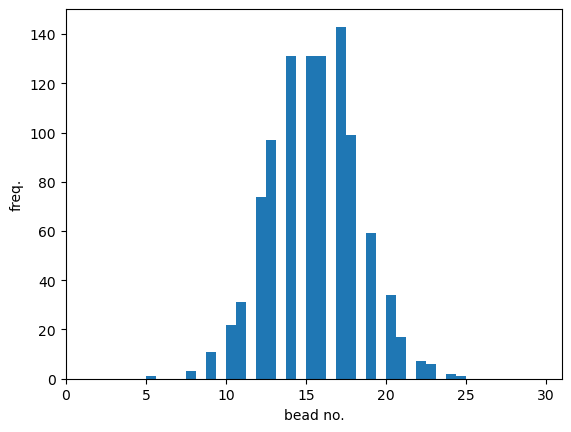

In [118]:
y = simulate_exp(0, 0)
y_list = freq_to_count(y)
#print(y_list)
print("Mean var skew mode")
print(summary_statistics(y_list))
x = experiment_data[0]
plt.hist(y_list, bins = 32)
plt.xlim(0,31)
plt.xlabel('bead no.')
plt.ylabel('freq.')

In [159]:
i_experiment = 0
num_simulations = 100
# Since the variance is used, h needs to be in scale of "number of beads off in the variance"
h = 1
repeats = 4
print(len(experiment_data))

accepted_alphas, acc_ratios, proposed_ses = abc_rejection_sampling(experiment_data, h, num_simulations, 
                                                                              rgs=rgs, repeats = repeats)

1000


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0.0048698191527712514
Accepted: 15.0%


  0%|          | 0/100 [00:00<?, ?it/s]

1.0810207091017218e-05
Accepted: 36.0%


  0%|          | 0/100 [00:00<?, ?it/s]

9.838538357799712e-11
Accepted: 34.0%


  0%|          | 0/100 [00:00<?, ?it/s]

9.291255054217284e-21
Accepted: 50.0%


<function matplotlib.pyplot.show(close=None, block=None)>

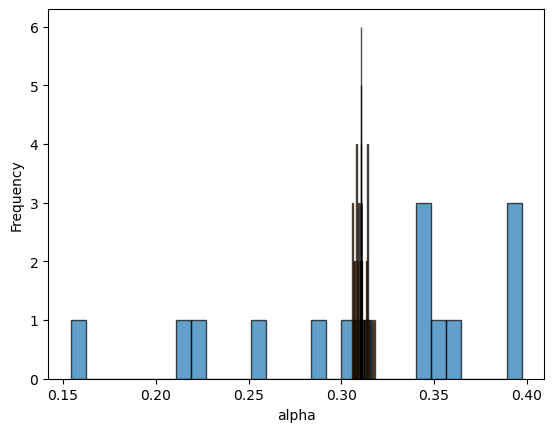

In [160]:
for i in range(repeats):
    plt.hist(accepted_alphas[i], bins = 30, edgecolor = 'black', alpha = 0.7)
plt.xlabel('alpha')
plt.ylabel('Frequency')
plt.show